In [1]:
import yaml
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import yaml
from pprint import pprint
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('./secret.yaml') as f:
    secret = yaml.safe_load(f)

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
                                                    client_id=secret['SPOTIFY_API_CLIENT_ID'], 
                                                    client_secret=secret['SPOTIFY_API_CLIENT_SECRET']), 
                    language='ja')

## 各国のウィークリートップ50曲を取得

In [3]:
weekly_top_playlist_ids_dict = dict(
    Global='37i9dQZEVXbNG2KDcFcKOF',  # グローバル
    Japan='37i9dQZEVXbKqiTGXuCOsB',  # 日本
    Korea='37i9dQZEVXbJZGli0rRP3r',  # 韓国
    America='37i9dQZEVXbLp5XoPON0wI',  # アメリカ
    Italy='37i9dQZEVXbJUPkgaWZcWG',  # イタリア
    India='37i9dQZEVXbMWDif5SCBJq',  # インド
    Brazil='37i9dQZEVXbKzoK95AbRy9',  # ブラジル
)

In [4]:
def get_playlist_tracks(playlist_ids:dict, playlist_len:int):

    tracks_df = pd.DataFrame(np.zeros((playlist_len*len(playlist_ids.keys()), 5)), \
                             columns=['country', 'weekly_rank', 'artist', 'title', 'uri'])
    for i, country in enumerate(tqdm(playlist_ids.keys())):
        playlist = sp.playlist(playlist_id=playlist_ids[country], market='JP')
        print(playlist['description'])
        tracks = playlist['tracks']['items']
        for j, track in enumerate(tracks):
            idx = (i*50) + j
            track_info = track['track']
            tracks_df.loc[idx, 'country'] = country
            tracks_df.loc[idx, 'weekly_rank'] = int(j+1)
            tracks_df.loc[idx, 'artist'] = track_info['artists'][0]['name']
            tracks_df.loc[idx, 'title'] = track_info['name']
            tracks_df.loc[idx, 'uri'] = track_info['uri']
    return tracks_df

In [5]:
tracks_df = get_playlist_tracks(playlist_ids=weekly_top_playlist_ids_dict, playlist_len=50)
tracks_df

  0%|          | 0/7 [00:00<?, ?it/s]

今、再生回数が一番多い曲 (毎週更新) - グローバル。
今、再生回数が一番多い曲 (毎週更新) - 日本。
今、再生回数が一番多い曲 (毎週更新) - 韓国。
今、再生回数が一番多い曲 (毎週更新) - アメリカ合衆国。
今、再生回数が一番多い曲 (毎週更新) - イタリア。
今、再生回数が一番多い曲 (毎週更新) - インド。
今、再生回数が一番多い曲 (毎週更新) - ブラジル。


,country,weekly_rank,artist,title,uri
0,Global,1.0,The Kid LAROI,STAY (with Justin Bieber),spotify:track:5PjdY0CKGZdEuoNab3yDmX
1,Global,2.0,リル・ナズ・X,INDUSTRY BABY (feat. Jack Harlow),spotify:track:27NovPIUIRrOZoCHxABJwK
2,Global,3.0,エド・シーラン,Bad Habits,spotify:track:6PQ88X9TkUIAUIZJHW2upE
3,Global,4.0,Måneskin,Beggin',spotify:track:3Wrjm47oTz2sjIgck11l5e
4,Global,5.0,カニエ・ウェスト,Hurricane,spotify:track:0RbW8kWozrVSIGb4V13o0o
...,...,...,...,...,...
345,Brazil,46.0,Jorge & Mateus,Paradigmas,spotify:track:17UfXrL7Run3GyZJW4uRjC
346,Brazil,47.0,Vitor Fernandes,Vou falar que não quero,spotify:track:6AMTUbWihFZOwOeHxZN2Ge
347,Brazil,48.0,Zé Neto & Cristiano,Vamo Tomar Uma,spotify:track:1YiO0AdZz9HNoJZr8nkaDR
348,Brazil,49.0,Hugo & Guilherme,Coração Na Cama - Ao Vivo,spotify:track:7vCvUJyjMxRkPeo19nxmuk


## 各曲の特徴量を取得

In [6]:
def get_playlist_features(tracks_df, use_features_list:list, chunk_n=100):

    tracks_df_idx_list = tracks_df.index.tolist()
    tracks_df_idx_chunk_list = [tracks_df_idx_list[i:i+chunk_n] for i in range(0, len(tracks_df_idx_list), chunk_n)]
    print(f"All:{len(tracks_df_idx_list)} -> ChunkSize:{chunk_n} | ChunkLength:{len(tracks_df_idx_chunk_list)}")

    for idx_chunk in tqdm(tracks_df_idx_chunk_list):
        tmp_df = tracks_df.loc[idx_chunk]
        uri_list = tmp_df.uri.tolist()
        sp_features_list = sp.audio_features(tracks=uri_list)
        for idx, sp_features in zip(idx_chunk, sp_features_list):
            for feature_name in use_features_list:
                tracks_df.loc[idx, feature_name] = sp_features[feature_name]
    return tracks_df

In [7]:
use_features_list = ['danceability', 'energy', 'speechiness', 'acousticness', 
                     'valence', 'tempo', 'liveness', 'duration_ms']
tracks_df = get_playlist_features(tracks_df=tracks_df, use_features_list=use_features_list, chunk_n=100)
tracks_df.head()

All:350 -> ChunkSize:100 | ChunkLength:4


  0%|          | 0/4 [00:00<?, ?it/s]

,country,weekly_rank,artist,title,uri,danceability,energy,speechiness,acousticness,valence,tempo,liveness,duration_ms
0,Global,1.0,The Kid LAROI,STAY (with Justin Bieber),spotify:track:5PjdY0CKGZdEuoNab3yDmX,0.591,0.764,0.0483,0.0383,0.478,169.928,0.1030,141806.0
1,Global,2.0,リル・ナズ・X,INDUSTRY BABY (feat. Jack Harlow),spotify:track:27NovPIUIRrOZoCHxABJwK,0.736,0.704,0.0615,0.0203,0.894,149.995,0.0501,212000.0
2,Global,3.0,エド・シーラン,Bad Habits,spotify:track:6PQ88X9TkUIAUIZJHW2upE,0.808,0.897,0.0348,0.0469,0.591,126.026,0.3640,231041.0
3,Global,4.0,Måneskin,Beggin',spotify:track:3Wrjm47oTz2sjIgck11l5e,0.714,0.800,0.0504,0.1270,0.589,134.002,0.3590,211560.0
4,Global,5.0,カニエ・ウェスト,Hurricane,spotify:track:0RbW8kWozrVSIGb4V13o0o,0.587,0.561,0.1460,0.0466,0.351,80.009,0.1090,243187.0


## Plotするための前準備

In [9]:
# 標準化
tracks_s_df = tracks_df.copy()
tracks_s_df[use_features_list] = tracks_df[use_features_list].apply(lambda x: (x-x.mean())/x.std(), axis=0)
tracks_s_df.head()

# Featuresを縦に結合(SeabornでBoxPlotを描写するため)
features_s_concat_df = pd.DataFrame()
for column_n in use_features_list:
    pick_col_list = [*tracks_s_df.columns.tolist()[0:5], column_n]
    col_df = tracks_s_df.loc[:, pick_col_list]
    col_df.rename(columns={column_n: 'value'}, inplace=True)
    col_df['feature_name'] = column_n
    features_s_concat_df = pd.concat([features_s_concat_df, col_df], axis=0)

In [10]:
features_s_concat_df

,country,weekly_rank,artist,title,uri,value,feature_name
0,Global,1.0,The Kid LAROI,STAY (with Justin Bieber),spotify:track:5PjdY0CKGZdEuoNab3yDmX,-0.447812,danceability
1,Global,2.0,リル・ナズ・X,INDUSTRY BABY (feat. Jack Harlow),spotify:track:27NovPIUIRrOZoCHxABJwK,0.601425,danceability
2,Global,3.0,エド・シーラン,Bad Habits,spotify:track:6PQ88X9TkUIAUIZJHW2upE,1.122425,danceability
3,Global,4.0,Måneskin,Beggin',spotify:track:3Wrjm47oTz2sjIgck11l5e,0.442230,danceability
4,Global,5.0,カニエ・ウェスト,Hurricane,spotify:track:0RbW8kWozrVSIGb4V13o0o,-0.476757,danceability
...,...,...,...,...,...,...,...
345,Brazil,46.0,Jorge & Mateus,Paradigmas,spotify:track:17UfXrL7Run3GyZJW4uRjC,-0.903755,duration_ms
346,Brazil,47.0,Vitor Fernandes,Vou falar que não quero,spotify:track:6AMTUbWihFZOwOeHxZN2Ge,-0.379545,duration_ms
347,Brazil,48.0,Zé Neto & Cristiano,Vamo Tomar Uma,spotify:track:1YiO0AdZz9HNoJZr8nkaDR,-1.220766,duration_ms
348,Brazil,49.0,Hugo & Guilherme,Coração Na Cama - Ao Vivo,spotify:track:7vCvUJyjMxRkPeo19nxmuk,-0.621492,duration_ms


## Plot

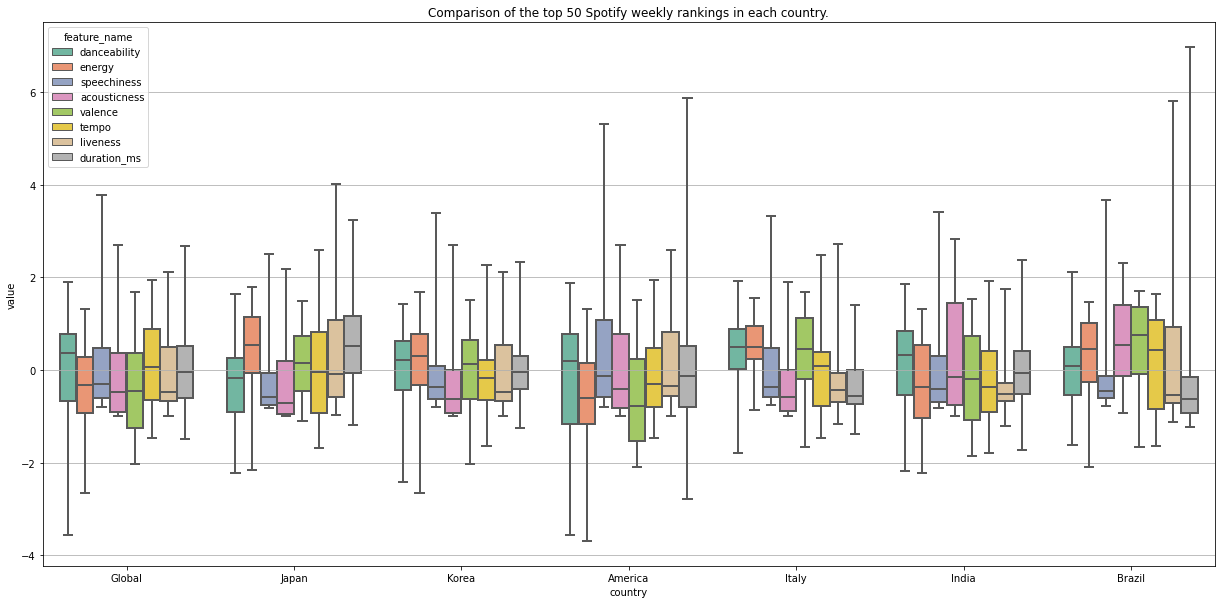

In [24]:
fig = plt.figure(figsize=(3*len(weekly_top_playlist_ids_dict), 10))
ax = fig.add_subplot(111)
ax.grid()
ax.set_title('Comparison of the top 50 Spotify weekly rankings in each country.')
ax = sns.boxplot(x='country', y="value", hue='feature_name',  data=features_s_concat_df, palette="Set2", whis=np.inf, linewidth=2)
fig.savefig('./top_50_comparison.pdf')
fig.savefig('./top_50_comparison.jpg')